In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
words = open('../names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# rebuild the dataset
# goal
# take sliding window of *block_size* across each name

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], [] # the inputs and outputs
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

torch.Size([228146, 3])
torch.Size([228146])


In [7]:
# now lets build the NN
# 1. build the embedding look up table C

# start by randomly initializing C
# shape is 27, 2 for 27 chars into 2 dim space
C = torch.randn((27, 2))

In [8]:
# two equivalent ways of access
# method 1 by direct access
C[5]

tensor([ 2.1087, -0.4389])

In [9]:
# method 2 by one-hot vector mlutiplication
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 2.1087, -0.4389])

In [10]:
# conclusion: we can actually think of the embedding lookup step as actually a MM!
# looks something like this
print(X[0], Y[0])
print(X[1], Y[1])

tensor([0, 0, 0]) tensor(5)
tensor([0, 0, 5]) tensor(13)


In [11]:
# for example 0:
# output of embedding lookup step for block size 3
# method 1
print(C[X[0]])
# output is shape 3,2

# method 2
# C is of shape 27,2
# output should be 3,27 x 27,2 = 3,2
print(F.one_hot(X[0], num_classes=27).shape)
print(C.shape)
print(F.one_hot(X[0], num_classes=27).float() @ C)

tensor([[-0.1511, -0.9235],
        [-0.1511, -0.9235],
        [-0.1511, -0.9235]])
torch.Size([3, 27])
torch.Size([27, 2])
tensor([[-0.1511, -0.9235],
        [-0.1511, -0.9235],
        [-0.1511, -0.9235]])


In [12]:
# ok now lets scale this up to dataset size

# method 1
C[X].shape

# method 2
# F.one_hot(X, num_classes=27).float() @ C

torch.Size([228146, 3, 2])

In [13]:
emb = C[X]

In [14]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [15]:
# concatentate and disparate emb chunks: (bs, 3, 2) -> (bs, 6)
example = torch.clone(C[X[:5]])
print(example)
example.view(-1, 6)

tensor([[[-0.1511, -0.9235],
         [-0.1511, -0.9235],
         [-0.1511, -0.9235]],

        [[-0.1511, -0.9235],
         [-0.1511, -0.9235],
         [ 2.1087, -0.4389]],

        [[-0.1511, -0.9235],
         [ 2.1087, -0.4389],
         [ 0.4123,  0.0806]],

        [[ 2.1087, -0.4389],
         [ 0.4123,  0.0806],
         [ 0.4123,  0.0806]],

        [[ 0.4123,  0.0806],
         [ 0.4123,  0.0806],
         [ 1.6385,  0.1919]]])


tensor([[-0.1511, -0.9235, -0.1511, -0.9235, -0.1511, -0.9235],
        [-0.1511, -0.9235, -0.1511, -0.9235,  2.1087, -0.4389],
        [-0.1511, -0.9235,  2.1087, -0.4389,  0.4123,  0.0806],
        [ 2.1087, -0.4389,  0.4123,  0.0806,  0.4123,  0.0806],
        [ 0.4123,  0.0806,  0.4123,  0.0806,  1.6385,  0.1919]])

In [16]:
# ok lets summarize so far and add the remaining
# this is the simulated forward pass
emb = C[X]
W1 = torch.randn((6,100))
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # shape is (bs, 100)

# need to have this as logits (output over our characters)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
print(logits.shape)

loss = F.cross_entropy(logits, Y)
print(loss)

torch.Size([228146, 27])
tensor(15.6570)


In [45]:
# setup
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [46]:
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

3481


In [17]:
# lets build the dataset
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

# now lets get the splits
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [50]:
# ok now lets add some batching and the like
lr = 0.1
train_loss = []
val_loss = []
num_train_samples = Xtrain.shape[0]
num_epochs = 2

def forward(X_ix, Y_ix):
    emb = C[X_ix]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_ix)
    return loss

for epoch in range(num_epochs):
    for step in range(num_train_samples):
        # construct the minibatch
        ix = torch.randint(0, num_train_samples, (32,))

        # forward
        loss = forward(Xtrain[ix], Ytrain[ix])
        train_loss.append(loss)

        # backward
        for p in parameters:
            p.grad = None
        loss.backward()

        # opt
        for p in parameters:
            p.data += -lr * p.grad

    # at the end of the epoch calculate the validation loss
    loss = forward(Xdev, Ydev)
    print(f"epoch {epoch}: {loss}")
    val_loss.append(loss)

epoch 0: 2.2635397911071777
epoch 1: 2.2566728591918945


In [21]:
# lets do all of that but now in torch
class NLM(torch.nn.Module):
    def __init__(self, vocab_size, vocab_dim, num_blocks, hidden_size):
        super().__init__()
        self.C = torch.nn.Parameter(torch.randn((vocab_size, vocab_dim)))
        self.W1 = torch.nn.Parameter(torch.randn((vocab_dim*num_blocks, hidden_size)))
        self.b1 = torch.nn.Parameter(torch.randn(hidden_size))
        self.W2 = torch.nn.Parameter(torch.randn((hidden_size, vocab_size)))
        self.b2 = torch.nn.Parameter(torch.randn(vocab_size))
    def forward(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, 6) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

In [46]:
def train(model, optimizer, train_steps, xtrain, ytrain, xdev, ydev):
    train_losses = []
    val_losses = []
    xtrain = xtrain.to("cuda")
    xdev = xdev.to("cuda")
    ytrain = ytrain.to("cuda")
    ydev = ydev.to("cuda")
    for i in range(train_steps):
        # get minibatch
        ix = torch.randint(0, xtrain.shape[0], (32,))

        # forward
        logits = model(xtrain[ix])

        # compute the loss
        loss = F.cross_entropy(logits, ytrain[ix])
        train_losses.append(loss.item())
        if i % 100 == 0:
            print(f"train: step {i}, {loss.item()}")

        # zero grad, backward, update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            logits = model(xdev)
            val_loss = F.cross_entropy(logits, ydev)
            val_losses.append(val_loss.item())
            print(f"val: step {i}, {val_loss.item()}")
    return train_losses, val_losses

In [47]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# now lets get the splits
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

model = NLM(27, 2, 3, 100)
model.to(device)

model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
train_loss, val_loss = train(model, optimizer, 1000, Xtrain, Ytrain, Xdev, Ydev)

Using device: cuda
train: step 0, 17.612552642822266
val: step 0, 15.979884147644043
train: step 100, 2.8838980197906494
val: step 100, 3.341428756713867
train: step 200, 2.937091112136841
val: step 200, 3.0974254608154297
train: step 300, 3.4136507511138916
val: step 300, 2.8196544647216797
train: step 400, 2.558624744415283
val: step 400, 2.8060953617095947
train: step 500, 3.0007307529449463
val: step 500, 2.7642946243286133
train: step 600, 2.469026565551758
val: step 600, 2.717906951904297
train: step 700, 2.7702956199645996
val: step 700, 2.6866540908813477
train: step 800, 2.3925397396087646
val: step 800, 2.6808624267578125
train: step 900, 3.186495304107666
val: step 900, 2.647329807281494


In [55]:
print(len(val_loss))
print(len(train_loss))
train_steps = list(range(len(train_loss)))
val_steps = list(range(0, 1000, 100))
print(len(val_steps))
print(len(val_loss))

10
1000
10
10


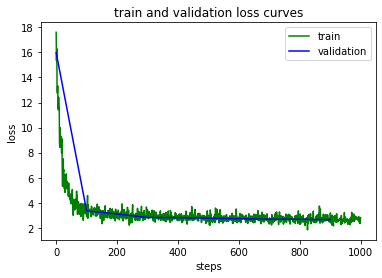

: 

In [56]:
plt.plot(train_steps, train_loss, 'g', label="train")
plt.plot(val_steps, val_loss, 'b', label="validation")
plt.title("train and validation loss curves")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()